In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

from pandeia_coronagraphy import scene, analysis, transformations, engine

from copy import deepcopy
import numpy as np

# Constructing a Scene

Setting up a calculation with MIRI is nearly identical to NIRCam (look at nircam_example.ipynb if you haven't already), with a few differences in the "detector" and "instrument" configuration.

We'll start by loading in a MIRI template initialized for the F1065C coronagraph, swap it to a F2300C Lyot observation, and add a single planet to the scene.

In [2]:
target = scene.load_calculation('../templates/miri_coronagraphy_template.json')

# change the filter
target['configuration']['detector']['subarray'] = 'masklyot'
target['configuration']['detector']['ngroup'] = 100
target['configuration']['instrument']['aperture'] = 'lyot2300'
target['configuration']['instrument']['filter'] = 'f2300c'

# pull out the target
targetstar = target['scene'][0]

# copy the target star and turn it into a planet
planetA = deepcopy(targetstar)
planetA['id'] = 2
planetA['position']['x_offset'] = 2.3
planetA['position']['y_offset'] = 3.1
planetA['spectrum']['normalization']['bandpass'] = 'miri,imaging,f1500w'
planetA['spectrum']['normalization']['norm_flux'] = 15.3
planetA['spectrum']['normalization']['type'] = 'jwst'
planetA['spectrum']['sed']['sed_type'] = 'blackbody'
planetA['spectrum']['sed']['temp'] = 900.
del planetA['spectrum']['sed']['key']

# update calculation file with new sources
target['scene'].extend([planetA])

#and add target acquisition error
errx, erry = scene.get_ta_error()
scene.offset_scene(target['scene'],errx,erry)

In [3]:
# and a reference PSF
reference = scene.load_calculation('../templates/miri_coronagraphy_template.json')

# change the filter
reference['configuration']['detector']['subarray'] = 'masklyot'
reference['configuration']['detector']['ngroup'] = 100
reference['configuration']['instrument']['aperture'] = 'lyot2300'
reference['configuration']['instrument']['filter'] = 'f2300c'

# we adopt a brighter but spectrally-mismatched reference (in part to demonstrate saturation)
refstar = reference['scene'][0]
refstar['spectrum']['normalization']['norm_flux'] = 4.7
refstar['spectrum']['sed']['key'] = 'a3v'

#and add target acquisition error
errx_ref, erry_ref = scene.get_ta_error()
scene.offset_scene(reference['scene'],errx_ref,erry_ref)

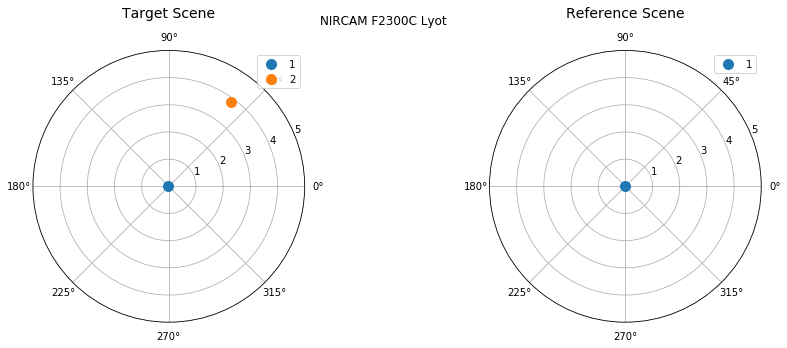

In [4]:
# and plot them
plt.figure(figsize=(15,5))
plt.subplot(121,polar=True)
scene.plot_scene(target['scene'],'Target Scene',newfig=False)
ax = plt.gca()
ax.set_rlim(0,5.)
plt.subplot(122,polar=True)
scene.plot_scene(reference['scene'],'Reference Scene',newfig=False)
ax = plt.gca()
ax.set_rlim(0,5.)

plt.suptitle('NIRCAM F2300C Lyot')

# Run the Pandeia Engine

Now we pass our calculation files to the pandeia engine to create the slope images (and a number of other products).

The most direct way to do so is to pass the calculation file to ```engine.perform_calculation.``` However, because the calculation is fairly time-consuming, ```scene.calculate_batch``` is provided as a convenience function for easy parallelization.


An aside on performance and accuracy: The ```engine.wave_sampling``` parameter provides a hook into the wavelength sampling of the 3D (x,y,wavelength) cube. By default, Pandeia adopts some large value for the wavelength sampling (typically 150+); however, this is the primary time sink in the calculation. Setting ```engine.wave_sampling = 10``` while developing your simulation provides dramatic time savings while getting within ~5% of the "true" value. By ```engine.wave_sampling = 40```, one can expect roughly 1% accuracy.

In [5]:
engine.wave_sampling = 20
targ_results, ref_results = scene.calculate_batch([target,reference])

/Users/kgorkom/anaconda/envs/pandeia/lib/python2.7/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)
/Users/kgorkom/anaconda/envs/pandeia/lib/python2.7/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


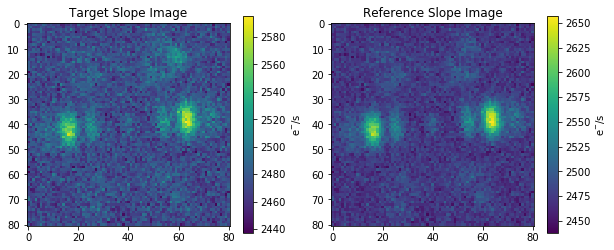

In [6]:
target_slope = targ_results['2d']['detector']
reference_slope = ref_results['2d']['detector']

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(target_slope)
plt.title('Target Slope Image')
plt.colorbar().set_label('e$^{-}$/s')
plt.subplot(122)
plt.imshow(reference_slope)
plt.title('Reference Slope Image')
plt.colorbar().set_label('e$^{-}$/s')

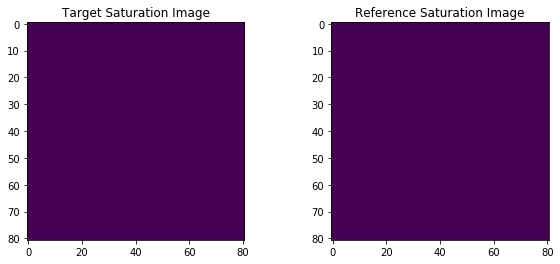

In [7]:
target_sat = targ_results['2d']['saturation']
reference_sat = ref_results['2d']['saturation']

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(target_sat)
plt.title('Target Saturation Image')
plt.subplot(122)
plt.imshow(reference_sat)
plt.title('Reference Saturation Image')

# Post-Processing

Subtract the registered and scaled reference PSF from the target image.

In [8]:
centered_target = target_slope - np.nanmean(target_slope)
centered_reference = reference_slope - np.nanmean(reference_slope)
centered_reference[np.isnan(centered_reference)] = np.nanmax(centered_reference)

registered_ref = analysis.register_to_target(centered_reference,centered_target)

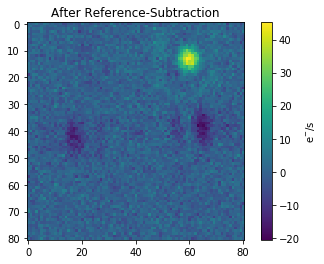

In [9]:
plt.imshow(centered_target - registered_ref)
plt.colorbar().set_label('e$^{-}$/s')
plt.title('After Reference-Subtraction')

# Save Calculation File

Save out your scene and instrument parameters for quick-loading with a future call to ```scene.load_calculation```

In [10]:
scene.save_calculation(target,'mygreatcalculation.json')

# Save Pandeia Images

```scene.save_to_fits``` is provided as a convenience function for quickly saving out arrays or cubes to a FITS file. This doesn't preserve any header values. See http://docs.astropy.org/en/stable/io/fits/ for a more complete treatment of reading and writings FITS files in Python.

In [11]:
scene.save_to_fits(targ_results['2d']['detector'],'target_slope.fits')
scene.save_to_fits(ref_results['2d']['detector'],'reference_slope.fits')

# More Complicated Things: Small-Grid Dithers and KLIP

To simulate a small-grid dither (SGD), pass in a reference calculation file (after adding TA error) to the ```scene.create_SGD``` function. By default, this only supports a square 9-point grid with 2 mas error on the grid points, but this function can be easily reproduced for other SGD configurations.

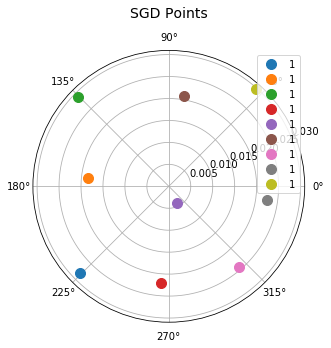

In [12]:
# set up the same reference
reference = scene.load_calculation('../templates/miri_coronagraphy_template.json')

# change the filter
reference['configuration']['detector']['subarray'] = 'masklyot'
reference['configuration']['detector']['ngroup'] = 100
reference['configuration']['instrument']['aperture'] = 'lyot2300'
reference['configuration']['instrument']['filter'] = 'f2300c'

# we adopt a brighter but spectrally-mismatched reference (in part to demonstrate saturation)
refstar = reference['scene'][0]
refstar['spectrum']['normalization']['norm_flux'] = 4.7
refstar['spectrum']['sed']['key'] = 'a3v'

# and a unique TA error
errx_ref, erry_ref = scene.get_ta_error()
scene.offset_scene(reference['scene'],errx_ref,erry_ref)

sgds = scene.create_SGD(reference,stepsize=20.e-3)

plt.figure(figsize=(5,5))
plt.subplot(111,polar=True)
for s in sgds:
    scene.plot_scene(s['scene'],'SGD Points',newfig=False)

Pass the SGD list to the pandeia engine

In [13]:
engine.wave_sampling = 20
sgd_results = scene.calculate_batch(sgds)

/Users/kgorkom/anaconda/envs/pandeia/lib/python2.7/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)
/Users/kgorkom/anaconda/envs/pandeia/lib/python2.7/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)
/Users/kgorkom/anaconda/envs/pandeia/lib/python2.7/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)
/Users/kgorkom/anaconda/envs/pandeia/lib/python2.7/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)
/Users/kgorkom/anaconda/envs/pandeia/lib/pyt

After registering the SGD observations to the target image, treat the SGD results as a reference library for KLIP and generate an artificial PSF for reference-subtraction

In [14]:
sgd_reg = []
for r in sgd_results:
    slope = r['2d']['detector']
    centered_slope = slope - np.mean(slope)
    reg = analysis.register_to_target(centered_slope,centered_target)
    sgd_reg.append(reg)
sgd_reg = np.array(sgd_reg)

artificialPSF = analysis.klip_projection(centered_target,sgd_reg)

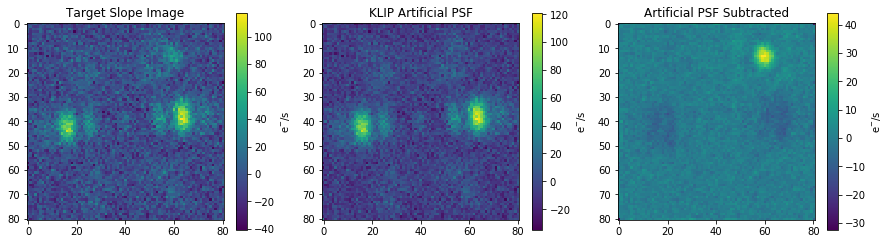

In [15]:
sgd_sub = centered_target - artificialPSF

plt.figure(figsize=(15,4))
plt.subplot(131)
plt.imshow(centered_target)
plt.title('Target Slope Image')
plt.colorbar().set_label('e$^{-}$/s')
plt.subplot(132)
plt.imshow(artificialPSF)
plt.title('KLIP Artificial PSF')
plt.colorbar().set_label('e$^{-}$/s')
plt.subplot(133)
plt.imshow(sgd_sub)
plt.title('Artificial PSF Subtracted')
plt.colorbar().set_label('e$^{-}$/s')